## Table of contents

1. Overview  

2. Import libraries 

3. Check overall information  

4. Data preprocessing  

5. Null and Alternative Hypothesis

6. Sampling distribution under the null

7. Confidence intervals  

8. Logistic Regression  

9. Conclusions








### 1. OVERVIEW

The company is trying new ad design to increase ad success.
To do so they made new creative advertising design with SmartAd brand and performed an A/B test in which one group of users have been shown an old ad and another - new one.

**Experiment Approach**

Our goal is to analyse the results of A/B test and figure out wherever new disign of ad affects the behavior of users in terms of responding to BIO questionnaire.

**Null Hypothesis** Hₒ: p = pₒ - There is no significant difference between the ad success rate of both groups  

**Alternative Hypothesis** Hₐ: p ≠ pₒ - There is significant difference between the ad success rate of both groups. Given we don’t know if the new design will perform better/worse/equal as our current design, we will perform a two-tailed test  

**Confidence Level:** 95% (α=0.05)

p and pₒ stand for the conversion rate of the new and old design.


### VariableName and Description 

**auction_id**	the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.

**experiment**	which group the user belongs to - control or exposed. **Control:** users who have been shown a dummy ad. **Exposed:** users who have been shown a creative, an online interactive ad, with the SmartAd brand.

**date**	the date in YYYY-MM-DD format

**hour**	the hour of the day in HH format

**device_make**	the name of the type of device the user has e.g. Samsung platform_os	the id of the OS the user has.

**browser**	the name of the browser the user uses to see the BIO questionnaire.

**yes**	1 if the user chooses the “Yes” radio button for the BIO questionnaire.

**no**	1 if the user chooses the “No” radio button for the BIO questionnaire.


### 2. Import libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import os


In [2]:
# Set up the format and styles for plots globally
sns.set_style('white')
plt.rc('axes', titlesize=13)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('legend', fontsize=11)
plt.rc('font', size=10)

In [3]:
# create path
path = r'/Users/macbook/Library/CloudStorage/OneDrive-Personal/Data Analisys/AB testing'


In [4]:
df = pd.read_csv(os.path.join(path, 'AdSmart.csv'))

In [5]:
df.head(10)


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
5,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
6,002e308b-1a07-49d6-8560-0fbcdcd71e4b,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
7,00393fb9-ca32-40c0-bfcb-1bd83f319820,control,2020-07-09,5,Samsung SM-G973F,6,Facebook,0,0
8,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
9,004c4cc9-f2ca-4df7-adc9-3d0c3c4f0342,control,2020-07-05,14,Generic Smartphone,6,Chrome Mobile,0,0


### 3. Check overall information

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [7]:
# Check for duplicates
if df.iloc[: ,0].nunique() == df.shape[0]:
    print('There are no duplicates in the dataset')
else:
    print('There are some duplicates in the dataset')

if df.isnull().sum().sum() == 0:
    print('There are no null values')
else:
    print('There are some null values')

There are no duplicates in the dataset
There are no null values


### 4. Data preprocessing

In this activity, I will be interested in a conversion rate. I will filter out the impressions where users neither clicked the yes button nor the no button. In other words, I will be doing multiple A/B tests to figure out whether the conversion rate with a new creative ad is higher than with a dummy ad.

In [8]:
# Filter out users that were not interacting
relevant_rows = df.query('yes == 1 | no == 1')

# Divide a dataframe by exposed and control group
exposed = relevant_rows.query('experiment == "exposed"')
control = relevant_rows.query('experiment == "control"')

# Calculate a number of observation in both groups
print('The exposed group dataframe has {} observations'. format(exposed.shape[0]))
print('The control group dataframe has {} observations'. format(control.shape[0]))

contr_d1 = '{0:.2f}%'.format(exposed.yes.mean()*100)
trtm_d1 = '{0:.2f}%'.format(control.yes.mean()*100)
print('The conversion rate in the exposed group is equal to {}'.format(contr_d1))
print('The conversion rate in the exposed group is equal to {}'.format(trtm_d1))

The exposed group dataframe has 657 observations
The control group dataframe has 586 observations
The conversion rate in the exposed group is equal to 46.88%
The conversion rate in the exposed group is equal to 45.05%


### 5. Null and Alternative Hypothesis

The null hypothesis would state that conversions would not change when using either the new creative ad or the dummy ad. We wanted to confirm the alternative hypothesis: the conversion rate of a new creative ad is higher than that of a dummy ad.

𝑁𝑢𝑙𝑙 (𝐻0) 𝑎𝑛𝑑 𝐴𝑙𝑡𝑒𝑟𝑛𝑎𝑡𝑖𝑣𝑒 (𝐻1) 𝐻𝑦𝑝𝑜𝑡ℎ𝑒𝑠𝑖𝑠
 
𝐻0: 𝑌𝑛𝑒𝑤− 𝑌𝑜𝑙𝑑=0
 
𝐻1: 𝑌𝑛𝑒𝑤− 𝑌𝑜𝑙𝑑>0

We need to set the significance level for the A/B test in advance. Let's say our alpha is 5%. This means that we will only reject the null hypothesis when the probability of observing a difference in sample proportions given that the null hypothesis is true is less than 5%. Since I'm interested in whether a new creative ad improves conversion rates, I'll use a one-tailed hypothesis test.

    

### 6. Sampling distribution under the null

In [9]:
obs_diff = exposed.yes.mean() - control.yes.mean()
obs_diff_form = '{0:.2f}%'.format(obs_diff*100)
print('The observed difference in the conversion rate between the exposed and the control group is {}'.format(obs_diff_form))


The observed difference in the conversion rate between the exposed and the control group is 1.83%


In [10]:
exposed_converted = exposed.query('yes == 1')
control_converted = control.query('yes == 1')
print('The sample sizes of the exposed group and control group are {} and {} respectively'.format(exposed.shape[0], control.shape[0]))
print('The number of conversions in the exposed group and control group is {} and {} respectively'.format(exposed_converted.shape[0],
                                                                                          control_converted.shape[0]))

The sample sizes of the exposed group and control group are 657 and 586 respectively
The number of conversions in the exposed group and control group is 308 and 264 respectively


In [11]:
#storing number of conversions for exposed and control groups as numpy arrays
count = np.array([exposed_converted.shape[0], control_converted.shape[0]])
#storing sample sizes of exposed and control group as numpy arrays
nobs = np.array([exposed.shape[0], control.shape[0]])
#storing results of z test in variables
stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')
p_form = '{0:.2f}%'.format(p_val*100)
print('P-value is equal to {}'.format(p_form))


P-value is equal to 25.92%


In [12]:
# Draw 100000 samples from binominal distribution
exposed_simulation = np.random.binomial(exposed.shape[0], exposed.yes.mean(), 100000)/exposed.shape[0]
control_simulation = np.random.binomial(control.shape[0], control.yes.mean(), 100000)/control.shape[0]
p_diffs = exposed_simulation - control_simulation
diffs = np.array(p_diffs)

#Creation of normal distribution centered at zero
null_vals = np.random.normal(0, np.std(diffs), len(diffs))

In [26]:
def statplot(data, lim, obs_stat, title):
    """
    This function creates a plot, that represents sampling distribution. 
    This plot is formatted and has main statistics on it
    Arguments:
    data = array
    lim = height of the plot
    obs_stat = observed statistic
    title = chart title
    """
    
    #Create a kdeplot
    plt.figure(figsize=(12,4), tight_layout=True)
    ax = sns.kdeplot(data, linewidth = 0.8, color = 'black')
    
    # Simple formatting
    frame = ['right', 'left', 'top']
    for i in frame:
        ax.spines[i].set_visible(False)

    plt.title(title)
    plt.ylabel('')
    plt.yticks([], [])
    
    # Legend
    line = Line2D([0], [0], color='red', linestyle = '-', label='observed statistic')
    line_dashed = Line2D([0], [0], color='black', linestyle = '--', label='mean and standard deviation')
    plt.legend(handles=[line, line_dashed], loc='upper left');
    
    # Create a list of 3 standard deviation to the left and to the right and mean
    std_list = []
    std_list_format = []
    for i in range(-3,4):
        std_dev = np.std(data) * i + np.mean(data)
        std_list.append(std_dev)
        std_list_format.append('{0:.3f}'.format(std_dev) + '\n {} std'.format(i))
        
    # Create a list of corresponding y values
    data_x, data_y = ax.lines[0].get_data()
    height = []
    for i in std_list:
        height.append(np.interp(i, data_x, data_y))
        
    # Plotting vertical lines representing std deviations 
    for a, b in zip(std_list, height):
        plt.axvline(a, 0, b/lim, color = 'black', alpha = 1, linewidth = 0.8, linestyle = '--')
        plt.plot(a, b, marker = 'o', color = 'blue')
    
    # Plotting observed statistic
    obs_line_height = np.interp(obs_stat, data_x, data_y)
    plt.axvline(obs_stat, 0, obs_line_height/lim, color = 'red', alpha = 1, linewidth = 0.8, linestyle = '-')
    plt.plot(obs_stat, obs_line_height, marker = 'o', color = 'red')
            
    # Plotting x ticks
    x_ticks = std_list
    x_labels = std_list_format
    plt.xticks(x_ticks, x_labels)
    plt.ylim(0,lim)


In [27]:
def shading(df, left, right, color):
    
    """
    This function shades areas of the kde plot.
    Arguments:
    df = array
    left = left boundary of the area to be shaded
    right = right boundary of the area to be shaded
    color = color
    """
    
    #Shading areas
    kde = stats.gaussian_kde(df)
    shade = np.linspace(left, right, 100)
    plt.fill_between(shade, kde(shade), color = color, alpha = 0.5);

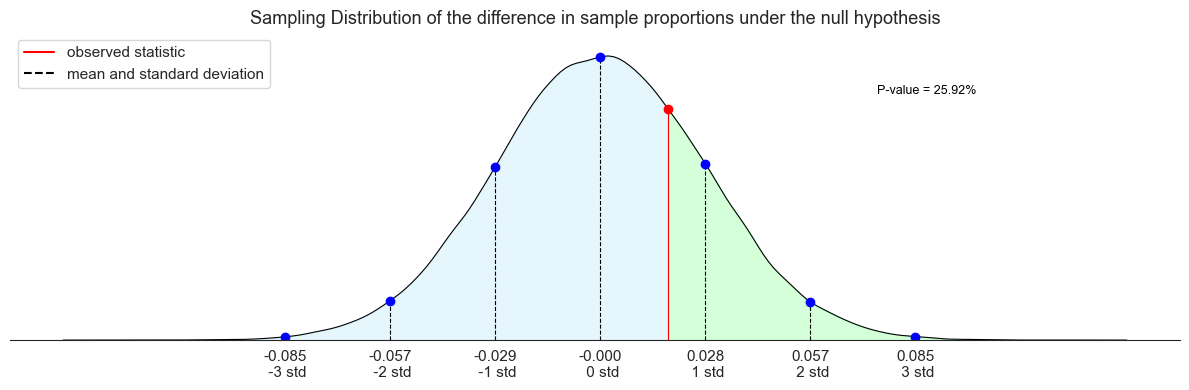

In [28]:
# Plotting the sampling distribution
statplot(null_vals, 15, obs_diff, 'Sampling Distribution of the difference in sample proportions under the null hypothesis') 
shading(null_vals, obs_diff, null_vals.max(),'#aaffb5') 
shading(null_vals, null_vals.min(), obs_diff,'#cceefb') 
plt.text(0.075, 12, "P-value = {}".format(p_form), color = 'black', size = 9); 

The graph above is the sampling distribution of the difference in sample proportions under the null hypothesis. The observed difference in conversion rates is between the mean and the first standard deviation. The green shaded area starts with the observed difference in conversion rate and extends to the right end, which represents differences greater than those observed. The probability that the observed difference falls within the null hypothesis sampling distribution is 25.92%. Given that our significance level is 5%, we cannot reject the null hypothesis, i.e. We don't have enough evidence to conclude that the conversion rate with the new creative is higher than with the dummy ad.

### 7. Confidence intervals

A/B testing can be done using confidence intervals. Hypothesis testing using confidence intervals involves conducting a two-sided hypothesis test. However, according to my alternative hypothesis, in which I want to prove that the conversion rate of the new creative ad is higher than that of the dummy ad, we want to conduct a one-sided hypothesis test. So I'll multiply my significance level by two, which gives me 5% x 2 = 10%. Thus, I want to prove that the mean of Hull's hypothesis falls outside the sampling distribution of the difference in sample proportions under the alternative hypothesis with 90% confidence.

In [29]:
# Calculate z statistic
zscore = stats.norm.ppf(1 - .05)

# Calculate mean proportion for exposed group
p1 = exposed.yes.mean()
# Calculate mean proportion for control group
p2 = control.yes.mean()
# Calculate distance from the mean
distance_from_mean = ((p1*(1-p1)/exposed.yes.shape[0]) + (p2*(1-p2)/control.yes.shape[0])) ** 0.5 * zscore

# Lower boarder of the interval
low = obs_diff - distance_from_mean
# Higher boarder of the interval
high = obs_diff + distance_from_mean

print('The 90% confidence interval falls between {} and {}.'.format(low, high))

The 90% confidence interval falls between -0.02828080835958243 and 0.06485204695055077.


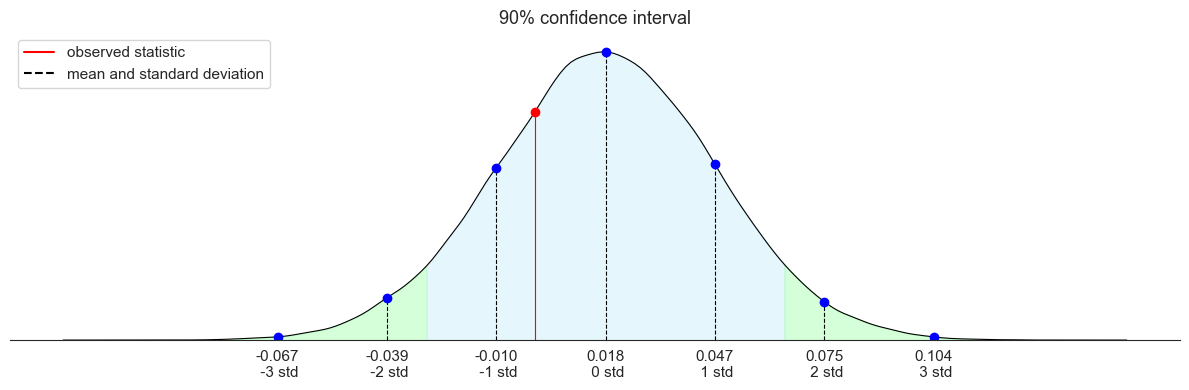

In [30]:
# Plotting the confidence interval
statplot(diffs, 15, np.mean(null_vals), '90% confidence interval')
shading(diffs, diffs.min(), low, '#aaffb5')
shading(diffs, low, high, '#cceefb')
shading(diffs, high, diffs.max(), '#aaffb5')

We can see here that our null hypothesis falls within the confidence interval. We can expect that 90% of confidence intervals would overlap with zero. Under the null hypothesis, our true difference in proportions is zero. Therefore, the P-value is higher than the significance level of 10%. (for the one-tailed test it would be 5%). Therefore, I do not have enough evidence to reject the null and suggest the alternative hypothesis.

### 8. Logistic Regression

Use the logistic regression to calculate P-value to see if there is a significant difference in conversion based on which ad a user receives

In [31]:
# Create dummy variables for experiment variable
relevant_rows[['control', 'exposed']] = pd.get_dummies(relevant_rows.loc[:, 'experiment'])
relevant_rows = relevant_rows.drop(['control'], axis = 1)
# Add intercept
relevant_rows['intercept'] = 1

#set up logistic regression model
logit_mod = sm.Logit(relevant_rows['yes'], relevant_rows[['intercept', 'exposed']])
#fitting logistic regression model
results = logit_mod.fit()
#display summary results
results.summary()

Optimization terminated successfully.
         Current function value: 0.689804
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    yes   No. Observations:                 1243
Model:                          Logit   Df Residuals:                     1241
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:               0.0002431
Time:                        22:03:22   Log-Likelihood:                -857.43
converged:                       True   LL-Null:                       -857.64
Covariance Type:            nonrobust   LLR p-value:                    0.5185
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1986      0.083     -2.392      0.017      -0.361      -0.036
exposed        0.0736      0.114      0.646      0.519      -0.150       0.297
==============================================================================
"""

If the P-value is high, then the variable is not significant and wise versa. Here, the P-value is 51.9%. Since logistic regression assumes that the test is two-sided and I conduct my test as one-sided, I will divide the P-value by 2 which will give me approx. 26%. Since 26% is higher than the level of significance, I fail to reject the null hypothesis in favor of the alternative.

### 9. Conclusions

I conducted A/B tests in three different ways. All versions suggest that the P-value is greater than the significance level and we do not have enough evidence to reject the null hypothesis.